# Learning Gaussians

In [1]:
import numpy as np

## Create the Gaussian Mixture Model

In [36]:
import numpy as np

class GaussianMixture:
    def __init__(self, parameters):

        self.parameters = parameters
        self.distributions = [
            {
                'mean': np.array(dist['mean']),
                'std': np.array(dist['std']),
                'cov': np.diag(np.array(dist['std']) ** 2)
            }
            for dist in parameters
        ]

    def sample(self, num_samples):
        samples = []
        num_distributions = len(self.distributions)
        for _ in range(num_samples):
            idx = np.random.randint(num_distributions)  # Choose a random Gaussian
            dist = self.distributions[idx]
            sample = np.random.multivariate_normal(mean=dist['mean'], cov=dist['cov'])
            samples.append(sample)
        return np.array(samples)

    def likelihood(self, points):
        likelihoods = np.zeros(points.shape[0])
        for dist in self.distributions:
            mean = dist['mean']
            cov = dist['cov']
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)

            # Multivariate Gaussian PDF
            factor = 1 / (2 * np.pi * np.sqrt(det_cov))
            diff = points - mean
            exponents = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            likelihoods += factor * np.exp(exponents)

        return likelihoods

## Visualize the data

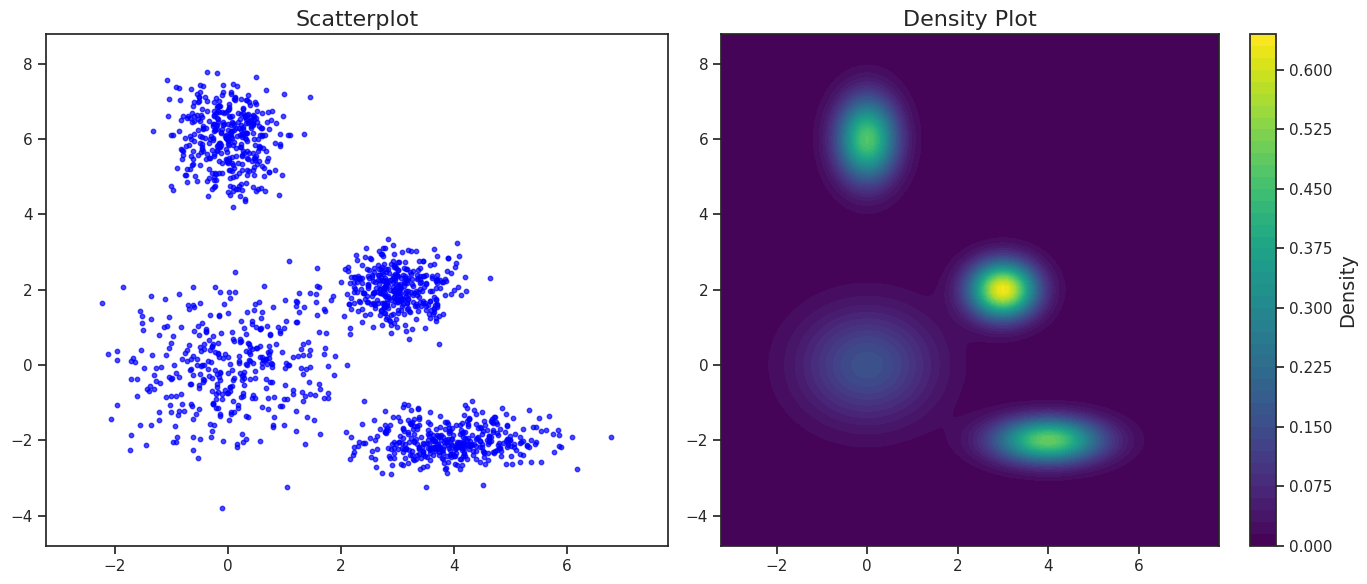

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="ticks")

def plot_gaussian_mixture(gm, samples, grid_size=100):

    x_min, x_max = np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1
    y_min, y_max = np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])
    densities = gm.likelihood(points).reshape(grid_size, grid_size)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    ax1 = axes[0]
    ax1.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, color="blue")
    ax1.set_title("Scatterplot", fontsize=16)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)

    ax2 = axes[1]
    contour = ax2.contourf(X, Y, densities, cmap="viridis", levels=50)
    cbar = fig.colorbar(contour, ax=ax2)
    cbar.set_label("Density", fontsize=14)
    ax2.set_title("Density Plot", fontsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

parameters = [
    {"mean": [0, 0], "std": [1, 1]},
    {"mean": [3, 2], "std": [0.5, 0.5]},
    {"mean": [0,6], "std": [0.45,0.75]},
    {"mean": [4,-2], "std": [0.8,0.4]},
]
gm = GaussianMixture(parameters)

samples = gm.sample(1500)
plot_gaussian_mixture(gm, samples)

## A Simple Normalizing Flow based on Affine Couplings

In [38]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):

        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class NVPBlock2D(nn.Module):
    def __init__(self, dim_flow, hidden_dim=256, flip=False):
        super().__init__()
        self.dim_flow = dim_flow
        self.hidden_dim = hidden_dim
        self.flip = flip

        self.f = FCNN((dim_flow // 2), dim_flow, hidden_dim)

    def shift_and_log_scale_fn(self, x1):
        s = self.f(x1)
        shift, log_scale = torch.chunk(s, 2, dim=1)
        return shift, log_scale

    def forward(self, x, ldj=None):
        d = self.dim_flow // 2
        x1, x2 = x[:, :d], x[:, d:]
        if self.flip:
            x1, x2 = x2, x1

        fcnn_input = x1

        shift, log_scale = self.shift_and_log_scale_fn(fcnn_input)
        y2 = x2 * torch.exp(log_scale) + shift

        if self.flip:
            x1, y2 = y2, x1
        z = torch.cat([x1, y2], dim=-1)

        if ldj is not None:
            ldj = ldj + log_scale.sum(dim=-1)

        return z, ldj

    def inverse(self, z, ldj=None):

        d = self.dim_flow // 2
        y1, y2 = z[:, :d], z[:, d:]
        if self.flip:
            y1, y2 = y2, y1

        fcnn_input = y1

        shift, log_scale = self.shift_and_log_scale_fn(fcnn_input)
        x2 = (y2 - shift) * torch.exp(-log_scale)  # Apply inverse affine transformation

        if self.flip:
            y1, x2 = x2, y1
        x = torch.cat([y1, x2], dim=-1)

        if ldj is not None:
            ldj = ldj - log_scale.sum(dim=-1)

        return x, ldj

class RealNVP2D(nn.Module):
    def __init__(self, dim_flow, steps=6, hidden_dim=256):
        super().__init__()
        self.flows = nn.ModuleList()
        flip = False

        for _ in range(steps):
            self.flows.append(NVPBlock2D(dim_flow, hidden_dim, flip=flip))
            flip = not flip

    def forward(self, x, num_layers=None):

        if num_layers is None:
            num_layers = len(self.flows)

        ldj = torch.zeros(x.shape[0], device=x.device)
        for flow in self.flows[:num_layers]:
            x, ldj = flow(x, ldj)
        return x, ldj

    def inverse(self, z, num_layers=None):

        if num_layers is None:
            num_layers = len(self.flows)

        ldj = torch.zeros(z.shape[0], device=z.device)
        for flow in list(reversed(self.flows[:num_layers])):
            z, ldj = flow.inverse(z, ldj)
        return z, ldj

## Setup Dataset and Train the Normalizing Flow


In [39]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def generate_2d_gaussian_mixture(num_samples, gm):
    samples = gm.sample(num_samples)
    return torch.tensor(samples, dtype=torch.float32)

def train_model(model, dataloader, optimizer, num_epochs=50, device="cuda"):
    model.train()
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x in dataloader:
            x = x[0].to(device)
            optimizer.zero_grad()

            z, ldj = model(x)
            prior = (-0.5 * z ** 2).sum(-1) - torch.log(torch.tensor(2.0 * torch.pi))
            loss = (-prior - ldj).mean()

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.utils import shuffle

samples = generate_2d_gaussian_mixture(50000, gm)
samples = shuffle(samples.numpy())
dataset = TensorDataset(torch.tensor(samples, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

dim_flow = 2
steps = 6
hidden_dim = 256

realnvp_model = RealNVP2D(dim_flow, steps, hidden_dim).to(device)
optimizer = torch.optim.Adam(realnvp_model.parameters(), lr=2e-4)

# Step 3: Train the model
num_epochs = 200
losses = train_model(realnvp_model, dataloader, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/200, Loss: 3.8080
Epoch 2/200, Loss: 3.5157
Epoch 3/200, Loss: 3.4711
Epoch 4/200, Loss: 3.4888
Epoch 5/200, Loss: 3.4330
Epoch 6/200, Loss: 3.4232
Epoch 7/200, Loss: 3.4205
Epoch 8/200, Loss: 3.4142
Epoch 9/200, Loss: 3.4047
Epoch 10/200, Loss: 3.4078
Epoch 11/200, Loss: 3.4046
Epoch 12/200, Loss: 3.3954
Epoch 13/200, Loss: 3.3929
Epoch 14/200, Loss: 3.3977
Epoch 15/200, Loss: 3.3895
Epoch 16/200, Loss: 3.3975
Epoch 17/200, Loss: 3.3833
Epoch 18/200, Loss: 3.3883
Epoch 19/200, Loss: 3.8748
Epoch 20/200, Loss: 3.6353
Epoch 21/200, Loss: 3.5450
Epoch 22/200, Loss: 3.5001
Epoch 23/200, Loss: 3.4865
Epoch 24/200, Loss: 3.4564
Epoch 25/200, Loss: 3.4489
Epoch 26/200, Loss: 3.4333
Epoch 27/200, Loss: 3.4230
Epoch 28/200, Loss: 3.4102
Epoch 29/200, Loss: 3.4082
Epoch 30/200, Loss: 3.4037
Epoch 31/200, Loss: 3.3949
Epoch 32/200, Loss: 3.3928
Epoch 33/200, Loss: 3.3929
Epoch 34/200, Loss: 3.3837
Epoch 35/200, Loss: 3.3887
Epoch 36/200, Loss: 3.3853
Epoch 37/200, Loss: 3.3770
Epoch 38/2

## Visualizing the Likelihood of the Trained Normalizing Flow

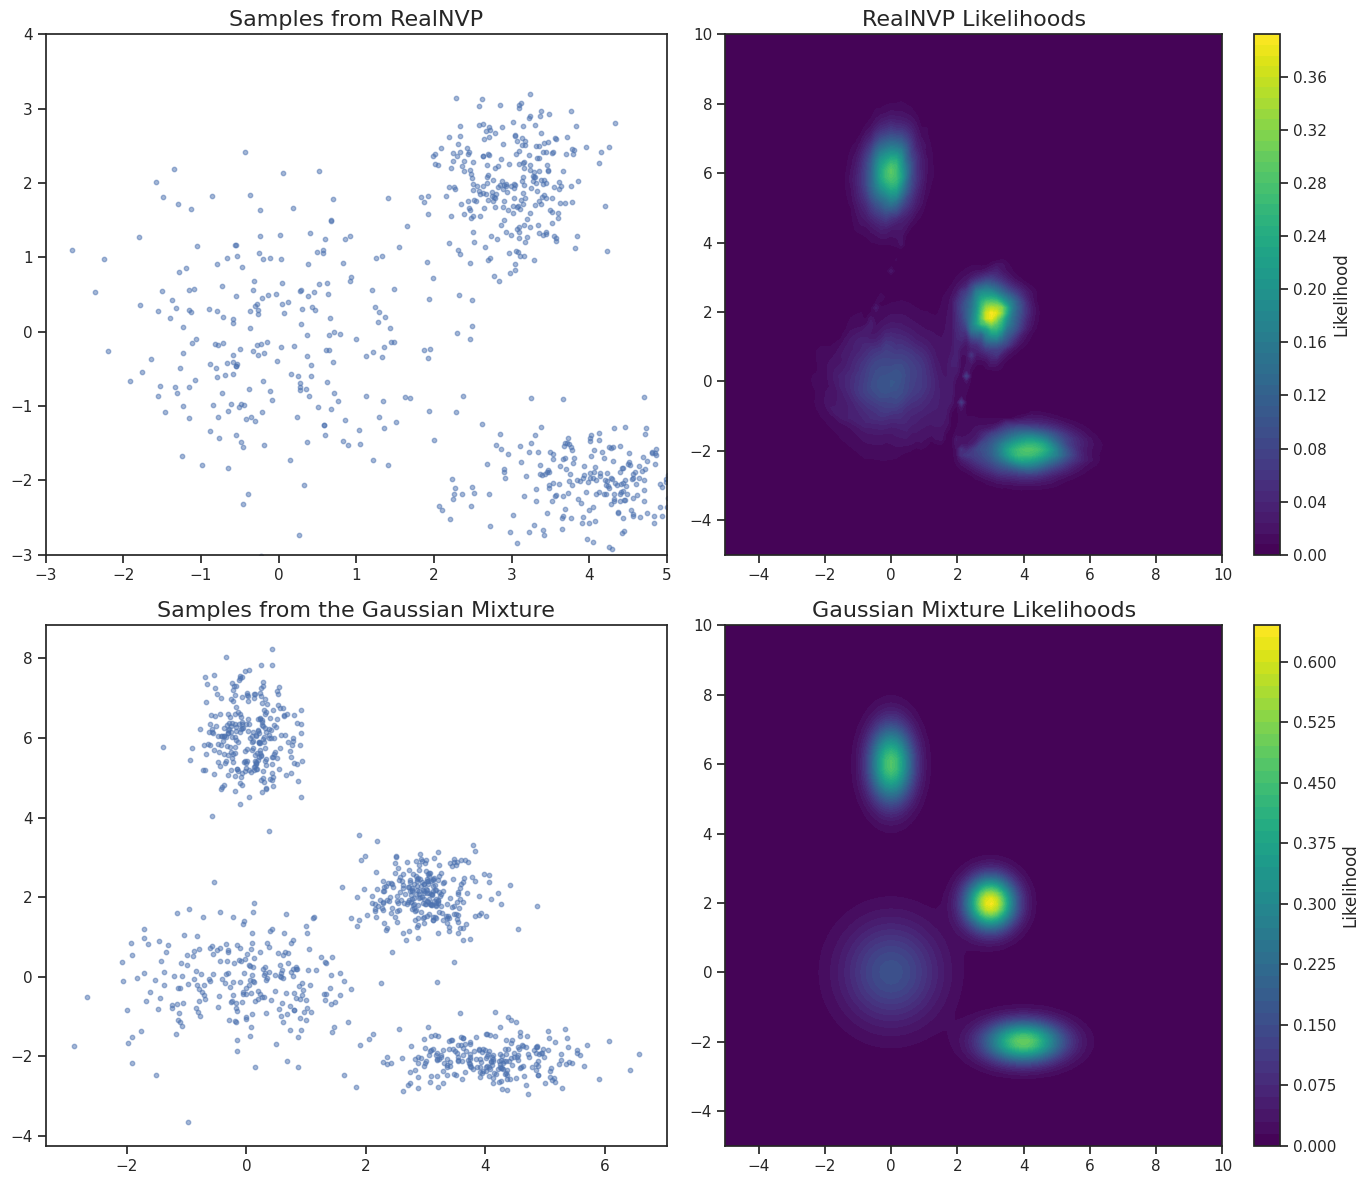

In [52]:
def visualize_training_results(model, gm, grid_size=100, dim=2, model_desc='Model'):

    model.eval()
    with torch.no_grad():
        z = torch.randn(1000, dim).to(device)
        samples, _ = model.inverse(z)

    samples = samples.cpu().numpy()
    gm_samples = gm.sample(1000)

    x = np.linspace(-5, 10, grid_size)
    y = np.linspace(-5, 10, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    with torch.no_grad():

        points_tensor = torch.tensor(points, device=device, dtype=torch.float32)
        z, ldj = model(points_tensor)
        prior = (-0.5 * z ** 2).sum(-1) - 0.5 * torch.log(torch.tensor(2.0 * torch.pi))
        model_likelihoods = torch.exp(prior + ldj).cpu().numpy().reshape(grid_size, grid_size)

        gm_likelihoods = gm.likelihood(points).reshape(grid_size, grid_size)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    axes[0, 0].scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.5, label="")
    axes[0, 0].set_title(f"Samples from {model_desc}", fontsize=16)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('')

    contour = axes[0, 1].contourf(X, Y, model_likelihoods, levels=50, cmap="viridis")
    fig.colorbar(contour, ax=axes[0, 1], label="Likelihood")
    axes[0, 1].set_title(f"{model_desc} Likelihoods", fontsize=16)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')

    axes[1, 0].scatter(gm_samples[:, 0], gm_samples[:, 1], s=10, alpha=0.5, label="")
    axes[1, 0].set_title("Samples from the Gaussian Mixture", fontsize=16)
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('')

    contour = axes[1, 1].contourf(X, Y, gm_likelihoods, levels=50, cmap="viridis")
    fig.colorbar(contour, ax=axes[1, 1], label="Likelihood")
    axes[1, 1].set_title("Gaussian Mixture Likelihoods", fontsize=16)
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')

    for i in range(1):
        for j in range(1):
            axes[i, j].set_xlim([-3,5])
            axes[i, j].set_ylim([-3,4])

    plt.tight_layout()
    plt.show()

visualize_training_results(realnvp_model, gm, model_desc='RealNVP')

# Visualizing Different Layers

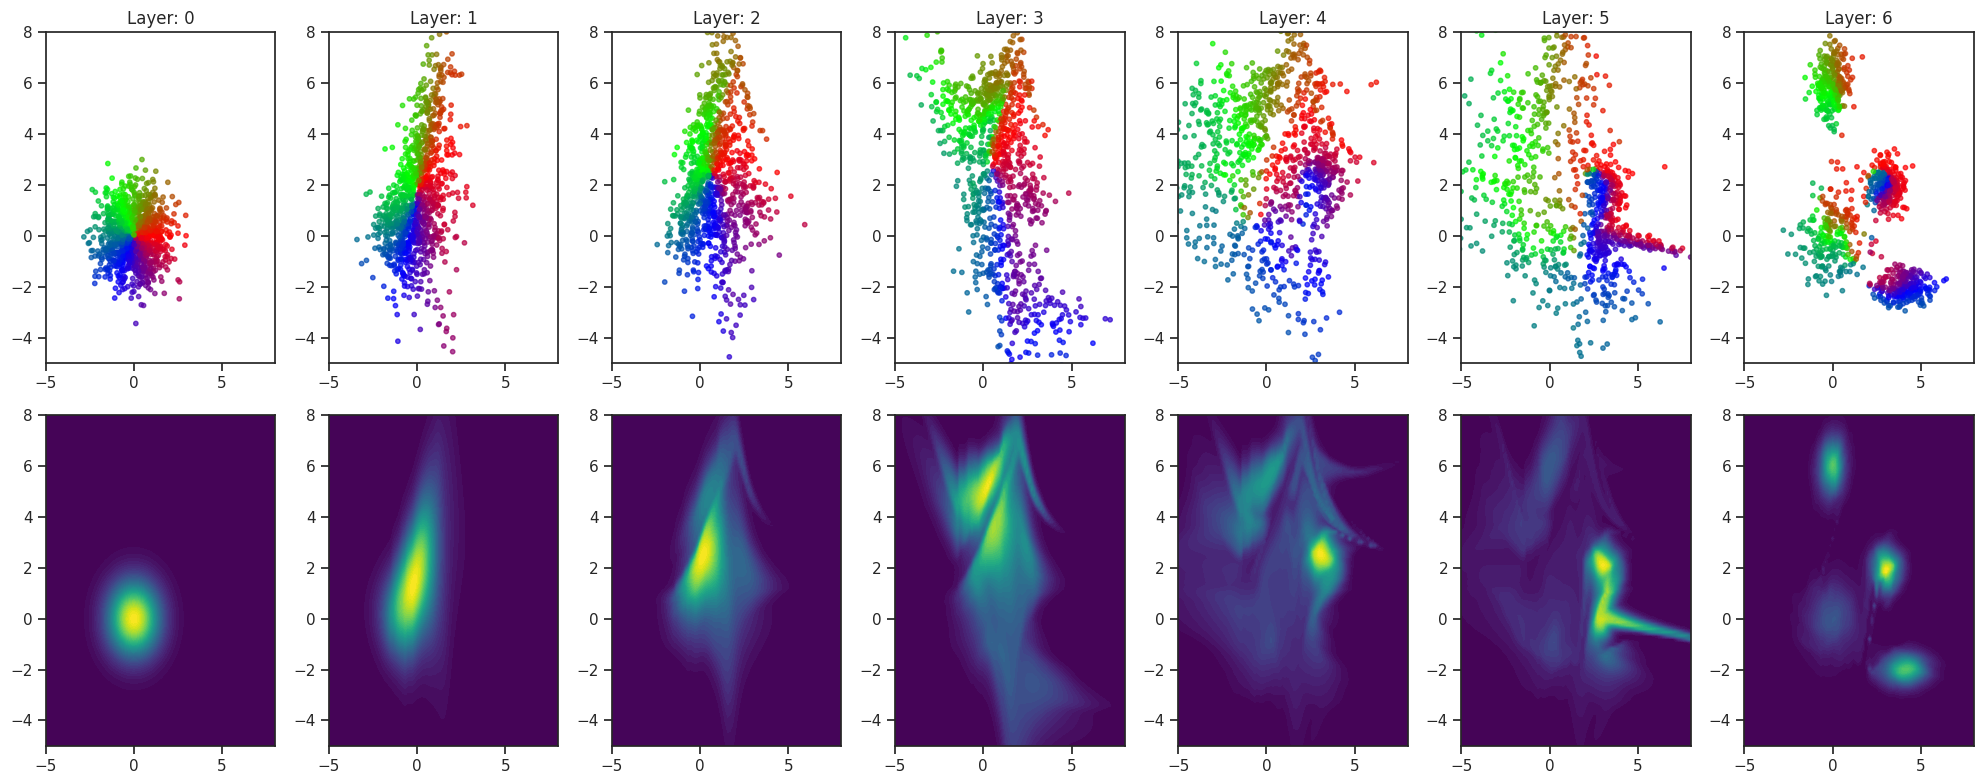

In [53]:
import matplotlib.pyplot as plt

def get_angle_colors(positions):
    angles = np.arctan2(positions[:, 1], positions[:, 0])
    angles_deg = (np.degrees(angles) + 360) % 360
    colors = np.zeros((len(positions), 3))
    for i, angle in enumerate(angles_deg):
        segment = int(angle / 120)
        local_angle = angle - segment * 120  # angle within segment [0, 120]
        if segment == 0:
            colors[i] = [1 - local_angle/120, local_angle/120, 0]
        elif segment == 1:
            colors[i] = [0, 1 - local_angle/120, local_angle/120]
        else:
            colors[i] = [local_angle/120, 0, 1 - local_angle/120]

    return colors

def visualize_progression_with_layers_and_likelihoods(model, grid_size=100, num_layers_max=6, num_samples=1000):

    model.eval()
    fig, axes = plt.subplots(2, num_layers_max + 1, figsize=(20, 8))

    x = np.linspace(-5, 8, grid_size)
    y = np.linspace(-5, 8, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])
    points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

    for num_layers in range(num_layers_max + 1):

        z = torch.randn(num_samples, model.flows[0].dim_flow).to(device)

        c = get_angle_colors(z.detach().cpu().numpy())

        with torch.no_grad():
            samples, _ = model.inverse(z, num_layers=num_layers)

        samples = samples.cpu().numpy()

        scatter_ax = axes[0, num_layers]
        scatter_ax.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c=c)
        scatter_ax.set_title(f"Layer: {num_layers}")
        scatter_ax.set_xlim(-5, 8)
        scatter_ax.set_ylim(-5, 8)
        scatter_ax.set_xlabel("")
        scatter_ax.set_ylabel("")

        with torch.no_grad():
            z, ldj = model(points_tensor, num_layers=num_layers)
            prior = (-0.5 * z ** 2).sum(-1) - 0.5 * torch.log(torch.tensor(2.0 * torch.pi))
            likelihoods = torch.exp(prior + ldj).cpu().numpy().reshape(grid_size, grid_size)

        likelihood_ax = axes[1, num_layers]
        contour = likelihood_ax.contourf(X, Y, likelihoods, levels=50, cmap="viridis")

        likelihood_ax.set_xlim(-5, 8)
        likelihood_ax.set_ylim(-5, 8)
        likelihood_ax.set_xlabel("")
        likelihood_ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

visualize_progression_with_layers_and_likelihoods(realnvp_model, grid_size=100, num_layers_max=6, num_samples=1000)

# Neural ODEs: Making Normalizing Flows Continuous

## Building a Continuous Normalizing Flow


In [40]:
import torch.nn as nn

def kernel_init_fn():
    return nn.init.xavier_uniform_

def bias_init_fn():
    return nn.init.zeros_

class ConcatSquash(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size

        self.lin1 = nn.Linear(in_size, out_size)
        self.lin2 = nn.Linear(1, out_size)
        self.lin3 = nn.Linear(1, out_size, bias=False)

        kernel_init = kernel_init_fn()
        kernel_init(self.lin1.weight)
        kernel_init(self.lin2.weight)
        kernel_init(self.lin3.weight)

        bias_init = bias_init_fn()
        bias_init(self.lin1.bias)
        bias_init(self.lin2.bias)

    def forward(self, t, y):
        if t.dim() == 0:
            t = t.view(1, 1)
        elif t.dim() == 1:
            t = t.view(-1, 1)

        return self.lin1(y) * torch.sigmoid(self.lin2(t)) + self.lin3(t)

class FFJORD(nn.Module):
    def __init__(self, data_size, width_size, depth):
        super().__init__()
        self.data_size = data_size
        self.width_size = width_size
        self.depth = depth

        layers = []

        if self.depth == 0:
            layers.append(ConcatSquash(in_size=data_size, out_size=self.data_size))
        else:
            layers.append(ConcatSquash(in_size=data_size, out_size=self.width_size))
            for _ in range(self.depth - 1):
                layers.append(ConcatSquash(in_size=width_size, out_size=self.width_size))
            layers.append(ConcatSquash(in_size=width_size, out_size=self.data_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, t, y):
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = torch.tanh(y)
        y = self.layers[-1](t, y)
        return y

In [40]:
import torch.nn as nn

def kernel_init_fn():
    return nn.init.xavier_uniform_

def bias_init_fn():
    return nn.init.zeros_

class ConcatSquash(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size

        self.lin1 = nn.Linear(in_size, out_size)
        self.lin2 = nn.Linear(1, out_size)
        self.lin3 = nn.Linear(1, out_size, bias=False)

        kernel_init = kernel_init_fn()
        kernel_init(self.lin1.weight)
        kernel_init(self.lin2.weight)
        kernel_init(self.lin3.weight)

        bias_init = bias_init_fn()
        bias_init(self.lin1.bias)
        bias_init(self.lin2.bias)

    def forward(self, t, y):
        if t.dim() == 0:
            t = t.view(1, 1)
        elif t.dim() == 1:
            t = t.view(-1, 1)

        return self.lin1(y) * torch.sigmoid(self.lin2(t)) + self.lin3(t)

class FFJORD(nn.Module):
    def __init__(self, data_size, width_size, depth):
        super().__init__()
        self.data_size = data_size
        self.width_size = width_size
        self.depth = depth

        layers = []

        if self.depth == 0:
            layers.append(ConcatSquash(in_size=data_size, out_size=self.data_size))
        else:
            layers.append(ConcatSquash(in_size=data_size, out_size=self.width_size))
            for _ in range(self.depth - 1):
                layers.append(ConcatSquash(in_size=width_size, out_size=self.width_size))
            layers.append(ConcatSquash(in_size=width_size, out_size=self.data_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, t, y):
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = torch.tanh(y)
        y = self.layers[-1](t, y)
        return y

## The Continuous Normalizing Flow Network

In [41]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

class CNFVelocityFn(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=8):
        super().__init__()

        self.net = FFJORD(data_size=input_dim, width_size=hidden_dim, depth=num_layers)

    def forward(self, t, combined_state):
        y, ldj = combined_state

        with torch.set_grad_enabled(True):
            y.requires_grad_(True)
            t.requires_grad_(True)

            t = torch.unsqueeze(t.repeat(y.shape[0]), 1)

            velocity = self.net(t, y)

            divergence = 0.0
            for i in range(y.shape[1]):
                divergence += torch.autograd.grad(velocity[:, i].sum(), y, create_graph=True)[0][:, i]

        return velocity, divergence.view(velocity.shape[0], 1)

class ContinuousNormalizingFlow(nn.Module):

    def __init__(self, input_dim, hidden_dim,
                 time_0=0.0, time_T=1.0):

        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.time_0 = time_0
        self.time_T = time_T

        self.velocity_fn = CNFVelocityFn(input_dim=input_dim, hidden_dim=hidden_dim)

    def solveODE(self, x, t):

        batch_size, dim = x.shape
        assert dim == self.input_dim, "Input dimension mismatch!"

        y0 = x
        ldj0 = torch.zeros(batch_size, device=x.device)

        combined_state = (y0, ldj0)

        result = odeint(self.velocity_fn, combined_state, t,
                        method='dopri5',
			            atol=[1e-5, 1e-5],
			            rtol=[1e-5, 1e-5],
                        )

        final_y, final_ldj = result

        return final_y[-1], final_ldj[-1]

    def forward(self, x):

        t = torch.tensor([self.time_0, self.time_T], device=x.device)

        return self.solveODE(x, t)

    def inverse(self, x):

        t = torch.tensor([self.time_T, self.time_0], device=x.device)

        return self.solveODE(x, t)

## Training

In [ ]:
samples = generate_2d_gaussian_mixture(10000, gm) # use fewer samples because training takes longer
samples = shuffle(samples.numpy())
dataset = TensorDataset(torch.tensor(samples, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

input_dim = 2
hidden_dim = 128
time_0 = 0.0
time_T = 1.0

cnf_model = ContinuousNormalizingFlow(input_dim=input_dim, hidden_dim=hidden_dim, time_0=time_0, time_T=time_T)

learning_rate = 2e-4
optimizer = torch.optim.Adam(cnf_model.parameters(), lr=learning_rate)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = train_model(cnf_model, dataloader, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/50, Loss: 8.7128
Epoch 2/50, Loss: 4.5683
Epoch 3/50, Loss: 4.4000


## Visualization of the Continuous Normalizing Flow

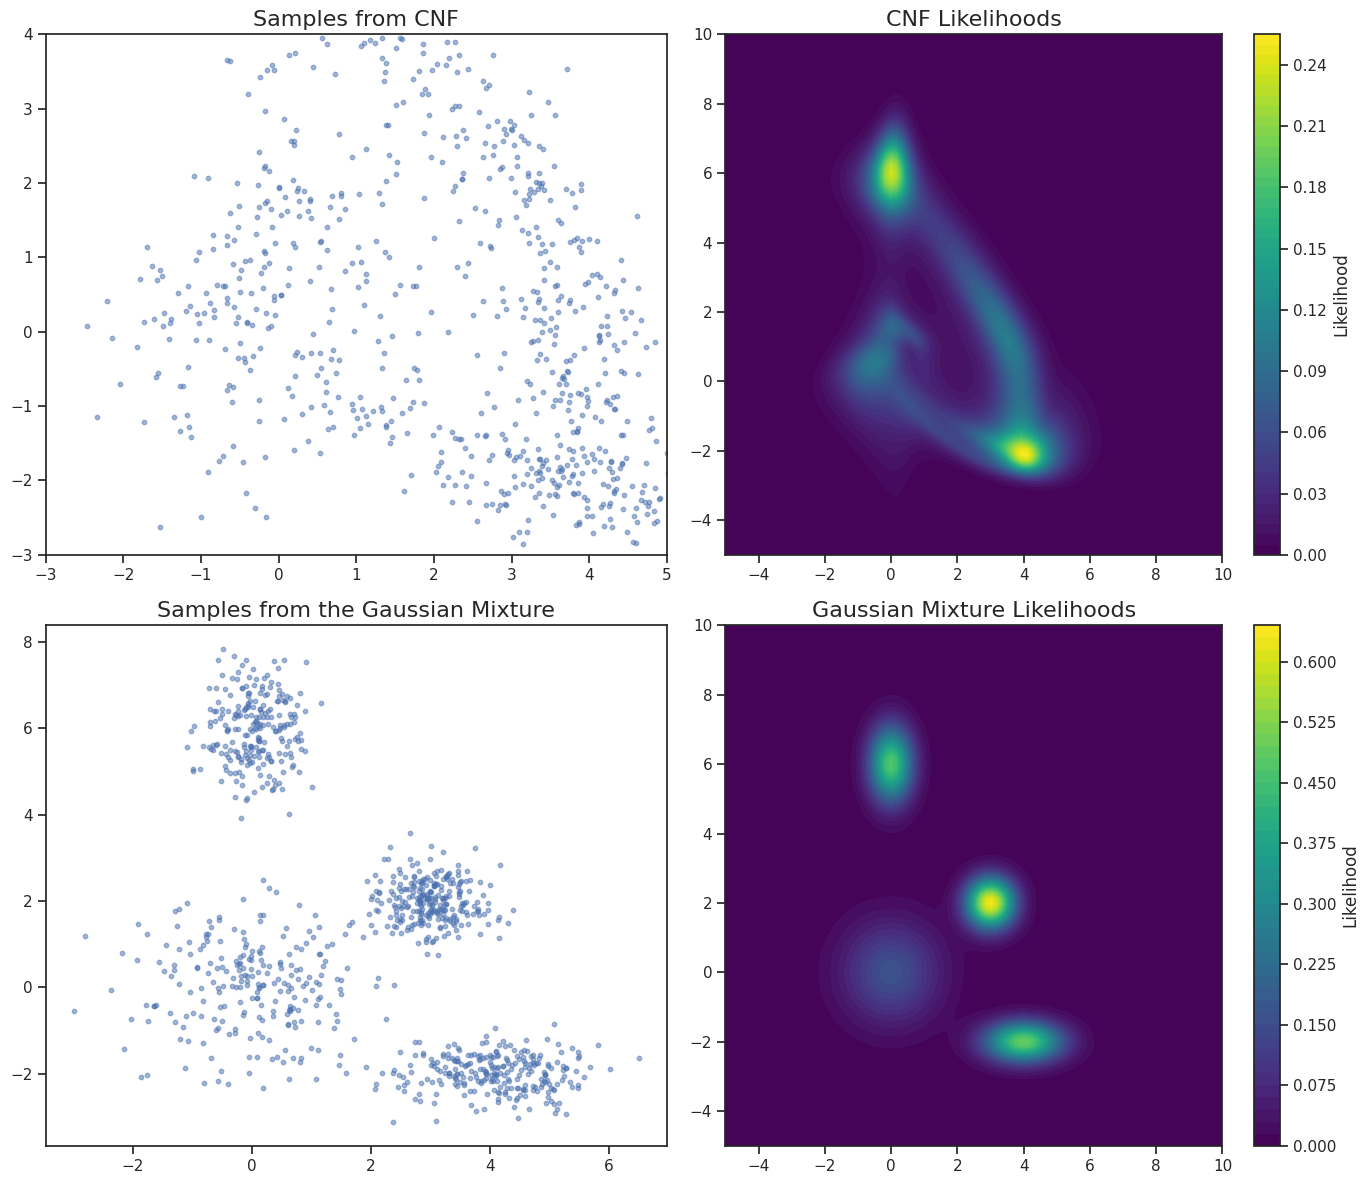

In [56]:
visualize_training_results(cnf_model.to(device), gm, 100, model_desc='CNF')